In [ ]:
! pip install rouge_score
! pip install -U accelerate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=4a10ea7293a9d18400e773526a8ca7b0f3381a00615025fbfe41e4cfc93f5f2d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 20.7 MB/s eta 0:00:00


In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 29.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=20cb49fde81cd091e9321487ba01d1ef731caf0d70b07d4b6247106c5cda2c87
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import glob
import wandb
import matplotlib.pyplot as plt

from io import StringIO
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch
from datasets import Dataset
from sklearn.metrics import f1_score
import numpy as np
import os

In [ ]:
import accelerate

In [ ]:
tqdm.pandas()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ["WANDB_PROJECT"] = "SciBERT" # name your W&B project
os.environ["WANDB_LOG_MODEL"] = "checkpoint" # log all model checkpoints

In [ ]:
def read_paper(path):
  f = open(path, 'r', encoding="utf-8")
  text = str(f.read())
  f.close()
  return text

In [ ]:
def create_list(folder_path):
  temp_papers = []
  for filename in tqdm(glob.glob(folder_path + "/*.txt")):
      temp_papers.append(read_paper(filename))
  for filename in tqdm(glob.glob(folder_path + "/*.xml")):
      temp_papers.append(read_paper(filename))
  return temp_papers

In [ ]:
train_path = '/content/drive/MyDrive/train'
val_path = '/content/drive/MyDrive/validation'
test_path = '/content/drive/MyDrive/test'

In [ ]:
list_train = create_list(train_path)
list_val = create_list(val_path)
list_test = create_list(test_path)

100%|██████████| 86/86 [00:00<00:00, 351.67it/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = "allenai/scibert_scivocab_uncased"

tokenizer = AutoTokenizer.from_pretrained(model)

model_compactbiobert = AutoModelForMaskedLM.from_pretrained(model).to(device)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    list_train,
    add_special_tokens=True,
    return_attention_mask=True,
    truncation=True,
    padding='longest',
    max_length=512,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    list_val,
    add_special_tokens=True,
    return_attention_mask=True,
    truncation=True,
    padding='longest',
    max_length=512,
    return_tensors='pt'
)

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15, return_tensors="pt")

In [ ]:
savePath = "/content/drive/MyDrive/models/"

In [ ]:
trainingArguments = TrainingArguments(
    savePath + "checkpoints",
    logging_steps=1,
    overwrite_output_dir=True,
    num_train_epochs=100,
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    do_train=True,
    do_eval=True,
    warmup_steps=5000,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=128,
    metric_for_best_model='eval_loss',
    weight_decay=1e-4,
    fp16=True,
    report_to="wandb",
    gradient_checkpointing=True,
    optim="adamw_torch",
    save_total_limit=2,
    remove_unused_columns=True,
    evaluation_strategy = 'steps',
    eval_steps = 1,
    save_strategy = "steps",
    load_best_model_at_end=True
)

In [ ]:
dataset_train = Dataset.from_dict(encoded_data_train)
dataset_val = Dataset.from_dict(encoded_data_val)

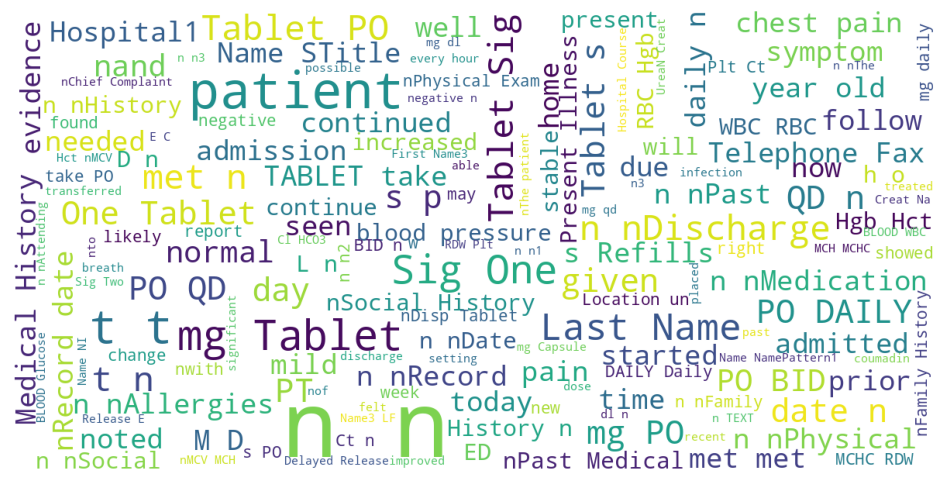

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(list_train)

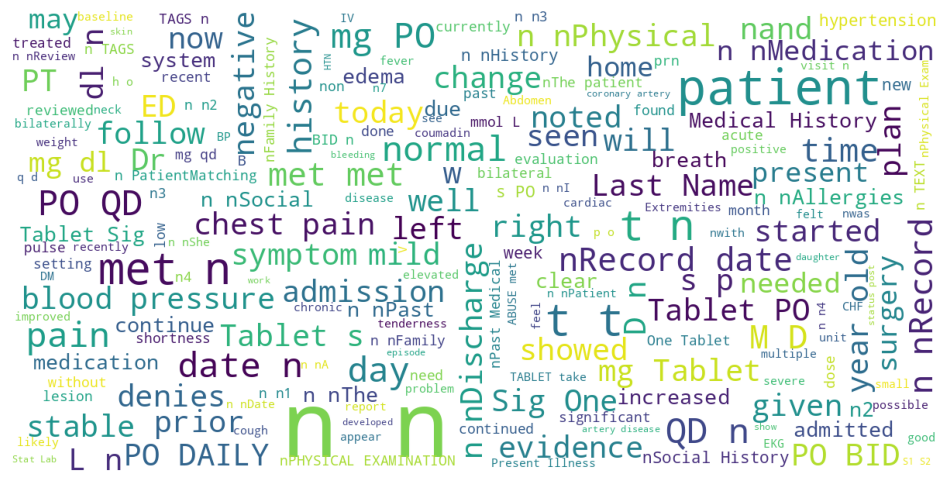

In [ ]:
show_wordcloud(list_val)

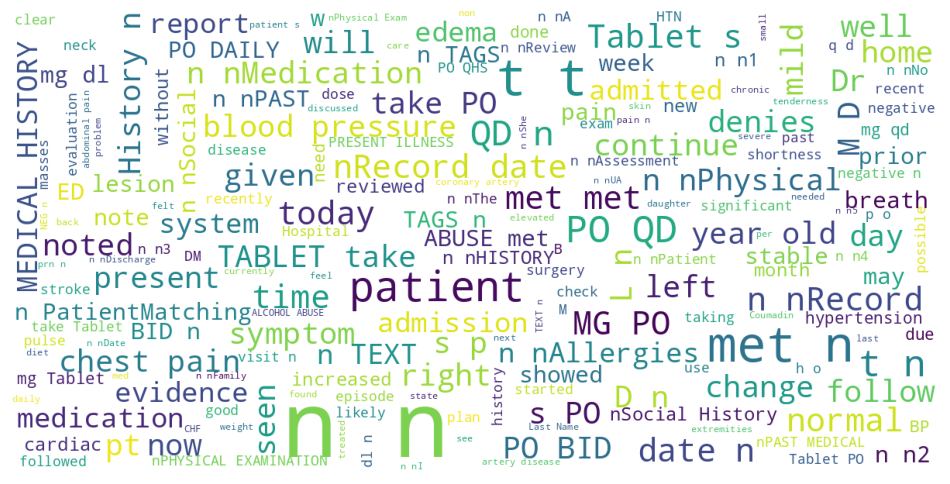

In [ ]:
show_wordcloud(list_test)

In [ ]:
print(len(min(list_train, key=len)))
print(len(min(list_val, key=len)))
print(len(min(list_test, key=len)))
print(len(max(list_train, key=len)))
print(len(max(list_val, key=len)))
print(len(max(list_test, key=len)))

615
710
4214
57334
33972
45140


In [ ]:
trainer = Trainer(model=model_compactbiobert, args=trainingArguments,
                  tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset=dataset_train,eval_dataset=dataset_val)

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1,0.365100,2.053028
2,0.366900,2.052314
3,0.367900,2.065605
4,0.364900,2.011359
5,0.367800,2.062397
6,0.361900,2.008445
7,0.034700,2.073716
8,0.329000,2.039159
9,0.363900,1.989602
10,0.366100,1.998011


TrainOutput(global_step=100, training_loss=0.3064624149352312, metrics={'train_runtime': 3870.3078, 'train_samples_per_second': 17.337, 'train_steps_per_second': 0.026, 'total_flos': 1.5188597618405376e+16, 'train_loss': 0.3064624149352312, 'epoch': 86.0})

In [ ]:
trainer.save_model(savePath + "SciBERT/")